# BERT - Experiments v2

This notebook contains AdHoc experiments with document representation using BERT/Transformer mechanisms then using them to perform document classification. This model will later be used to classify corpora of messages and dicern if they are related to a particular set of products and services.

#### Note
This notebook generates artifacts during its process, or expects some of them to be available within the artifacts directory.

In [1]:
!mkdir -p artifacts/models/keras artifacts/models/sklearn artifacts/results artifacts/results/logs artifacts/results/checkpoints

In [2]:
import os

os.environ['MODIN_CPUS'] = "10"
os.environ['MODIN_OUT_OF_CORE'] = "true"

artifacts_path = os.path.join(os.path.curdir, 'artifacts/')
models_path = os.path.join(artifacts_path, 'models/')
sklearn_models = os.path.join(models_path, 'sklearn/')
kears_modesl = os.path.join(models_path, 'keras/')
results_path = os.path.join(artifacts_path, 'results/')
logs_path = os.path.join(results_path, 'logs/')
data_path = os.path.join(artifacts_path, 'data/')

## Document Tokenization

Before feeding data to the neural network, we need to pre-process the raw text data. This process is costly, hence I've used Apache spark to pre-process it. This makes it a very fast process and it will also prepare the batches to create generators so we can feed them to the network.

In [3]:
%%time
%%bash
# 1.5 million records
#export raw_reviews="/media/ohtar10/Adder-Storage/datasets/pre-processed/product-documents-small-shuffle/"

# 8 million records
export raw_reviews="/media/ohtar10/Adder-Storage/datasets/pre-processed/13-pct-documents"

# 59 million records (Warning, this required either a spark cluster or a very powerful machine with more than 32GB of ram)
#export raw_reviews="/media/ohtar10/Adder-Storage/datasets/pre-processed/product-documents/"

export current_dir=$(pwd)
if [ ! -d "artifacts/data/" ]; then
    spark-submit --driver-memory 16G ../../../dataprep/scripts/document_tokenizer.py --input "${raw_reviews}" --output "${current_dir}/artifacts/data/" --column document --vocab-size 1000000 --maxlen 300 --batch-size 1000 > spark.log
fi

 20 non-empty blocks including 20 local blocks and 0 remote blocks
20/11/27 17:31:06 INFO ShuffleBlockFetcherIterator: Started 0 remote fetches in 0 ms
20/11/27 17:31:06 INFO FileOutputCommitter: File Output Committer Algorithm version is 1
20/11/27 17:31:06 INFO SQLHadoopMapReduceCommitProtocol: Using user defined output committer class org.apache.parquet.hadoop.ParquetOutputCommitter
20/11/27 17:31:06 INFO FileOutputCommitter: File Output Committer Algorithm version is 1
20/11/27 17:31:06 INFO SQLHadoopMapReduceCommitProtocol: Using output committer class org.apache.parquet.hadoop.ParquetOutputCommitter
20/11/27 17:31:06 INFO FileOutputCommitter: File Output Committer Algorithm version is 1
20/11/27 17:31:06 INFO SQLHadoopMapReduceCommitProtocol: Using user defined output committer class org.apache.parquet.hadoop.ParquetOutputCommitter
20/11/27 17:31:06 INFO FileOutputCommitter: File Output Committer Algorithm version is 1
20/11/27 17:31:06 INFO CodecConfig: Compression: SNAPPY
20/11

In [4]:
!printf "Total batches: %s" $(ls artifacts/data/*.parquet | wc -l)

Total batches: 8073

### Category encoder

Load the category encoder. If the encoder does not exist, please refer to the [bert-experiments.ipynb](!bert-experiments.ipynb) which is were it gets generated.

In [7]:
import pickle

categories_encoder_path = os.path.join(sklearn_models, 'category_encoder.pkl')
categories_encoder = None
with open(categories_encoder_path, 'rb') as file:
    categories_encoder = pickle.load(file)

### Word index
Similarly, let's load the word index generated by the spark job. This is useful if we want to transform new raw text entries into its tokenized/encoded form.

In [8]:
word_index_path = os.path.join(data_path, 'word_index.pkl')
with open(word_index_path, 'rb') as file:
    word_index = pickle.load(file)

## Prepare a Keras Generator
The amount of data we are going to load is massive, and probably it will not fit in memory. Hence, we will use a Keras generator/Sequence to feed batch by batch the records into the model and avoid loading all the data set into memory. The spark job that tokenizes the raw input also outputs batch files of a predetermined size, so the idea of this generator is to load each individual file one by one, so each file is one batch.

In [5]:
import tensorflow.keras as keras
import glob
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DocumentDataGenerator(Sequence):
    def __init__(self, fileset, 
        doc_column, 
        cat_column,
        category_encoder,
        transform=False,
        word_index=None,
        maxlen=None,
        shuffle=True, 
        to_fit=True):
        self.doc_column = doc_column
        self.cat_column = cat_column
        self.category_encoder = category_encoder
        self.transform = transform
        self.word_index = word_index
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.fileset = fileset
        self.maxlen = maxlen

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.fileset)

    def __getitem__(self, index):
        """Generate one batch of data"""
        df = pd.read_parquet(self.fileset[index], columns=[self.doc_column, self.cat_column])
        if self.shuffle:
            df = df.sample(frac=1)
        if self.transform:
            X = self.__transform(df)
        else:
            X = df[self.doc_column].values
            X = np.array(X.tolist())
        y = df[self.cat_column].apply(lambda cat: cat.split(";")).values.tolist()

        if self.to_fit:
            y = self.category_encoder.transform(y)
            return X, y
        else:
            return X

    def __transform(self, X):
        def tokenize(row):
            tokens = [self.word_index[token] for token in row if token in self.word_index]
            return [0] * (self.maxlen - len(tokens)) + tokens[:self.maxlen]
        
        words = X[self.doc_column].str.lower().str.split(f'[^\w+]', expand=True)
        return words.apply(tokenize, axis=1, result_type='expand').values


Now we simply load fetch all the files generated by the spark job, and generate the train/dev/test sets, and subsequently, we generate the generators for each.

In [17]:
import glob
from sklearn.model_selection import train_test_split

fileset = [file for file in glob.glob(f"{data_path}/*.parquet", recursive=True)]

train, test = train_test_split(fileset, test_size=0.2, random_state=123)
dev, test = train_test_split(test, test_size=0.5, random_state=123)


train_gen = DocumentDataGenerator(train, 'tokenized_document', 'categories', categories_encoder)
dev_gen = DocumentDataGenerator(dev, 'tokenized_document', 'categories', categories_encoder)
test_gen = DocumentDataGenerator(test, 'tokenized_document', 'categories', categories_encoder)

## Defining the Attention based text classifier

Resources: 
* https://keras.io/examples/nlp/text_classification_with_transformer/
* [Attention is all you need](!https://arxiv.org/abs/1706.03762)

Here we define the network architecture of the model as a multi-head self attention. This basically uses the Encoder part of the Attention mechanism to encode the context, i.e., the text describing the category, then passing its output to a fully connected network. Since in this case we do not need to answer questions, nor perform translation, the decoder part is not necessary.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Implement multi head self attention as Keras layer

In [11]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimmension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs) # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs) # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs) # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        ) # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            query, batch_size
        ) # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            query, batch_size
        ) # (batch_size, num_heads, seq_len, projection_dim)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        ) # (batch_size, seq_len, embed_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        ) # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        ) # (batch_size, seq_len, embed_dim)
        return output


### Implement a Transformer block as a layer

In [12]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(embed_dim)
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Implement embedding layer

In [13]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [12]:
embed_dim = 128 # Embedding size for each token
num_heads = 2 # number of attention heads
ff_dim = 64 # Hidden layer size in feed forward network inside transformer

# Note: these below were already defined a some cells above. Redefinding them to remember them
maxlen = 300 # Only consider the first 300 words of each product review
vocab_size = 1000000 # Only consider the top 200k words

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(216, activation='relu')(x)

outputs = layers.Dense(len(categories_encoder.classes_), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
token_and_position_embedding (None, 300, 128)          128038400 
_________________________________________________________________
transformer_block (Transform (None, 300, 128)          83136     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0     

### Train and evaluate the model

In [13]:
%%time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

checkpoints_path = os.path.join(results_path, 'checkpoints/')
logs_path = os.path.join(results_path, 'logs/')
callbacks = [
    EarlyStopping(monitor='loss', patience=3, min_delta=1e-7, restore_best_weights=True),
    TensorBoard(log_dir=logs_path),
    ModelCheckpoint(checkpoints_path, monitor='val_acc')
]

optimizer = Adam(learning_rate=1e-4)

# losses
# kullback_leibler_divergence
# categorical_hinge
# categorical_crossentropy
model.compile(optimizer="adam", loss='kullback_leibler_divergence', metrics=['accuracy'])
history = model.fit(train_gen, epochs=5, validation_data=dev_gen, callbacks=callbacks)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6458 steps, validate for 807 steps
Epoch 1/5
6457/6458 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.8393WARNING:tensorflow:From /home/ohtar10/miniconda3/envs/wtsp/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./artifacts/results/checkpoints/assets
6458/6458 [==============================] - 6160s 954ms/step - loss: 0.5911 - accuracy: 0.8393 - val_loss: 0.5150 - val_accuracy: 0.8504
Epoch 2/5
6458/6458 [==============================] - 6541s 1s/step - loss: 0.4972 - accuracy: 0.8646 - val_loss: 0.5166 - val_accuracy: 0.8609
Epoch 3/5
6458/6458 [==============================] - 6291s 974ms

In [14]:
model.evaluate(test_gen)

  ...
    to  
  ['...']
808/808 [==============================] - 77s 95ms/step - loss: 0.4918 - accuracy: 0.8649


[0.49178860827100157, 0.8649236]

In [32]:
%%time
from sklearn.metrics import classification_report, accuracy_score

y_true = []
X = []
for i in range(len(test_gen)):
    x, y = test_gen.__getitem__(i)
    y_true.extend(y)
    X.extend(x)

y_true = np.array(y_true)
X = np.array(X)

y_pred = model.predict(X)
y_pred = np.where(y_pred > 0.5, 1., 0.)

# compute accuracy score
acc = accuracy_score(y_true, y_pred)
# compute the classification report
cr = classification_report(y_true, y_pred)

CPU times: user 3min 54s, sys: 54.4 s, total: 4min 49s
Wall time: 3min


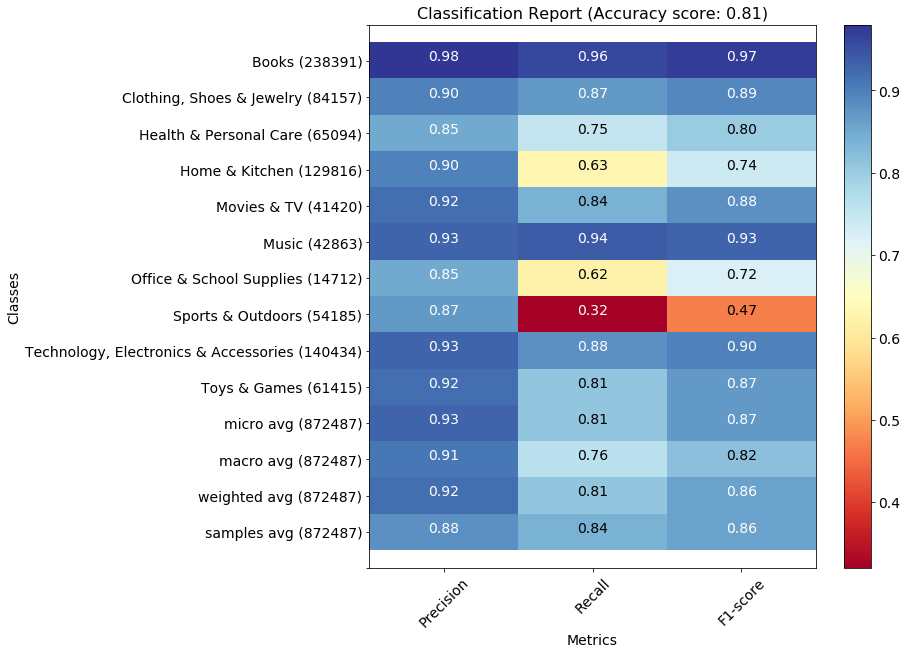

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools

class_labels = categories_encoder.classes_
title = f"Classification Report (Accuracy score: {acc:.2f})"
cmap="RdYlBu"

cr = cr.replace("\n\n", "\n")
cr = cr.replace(" / ", "/")
lines = cr.split("\n")

classes, plot_mat, support = [], [], []
for line in lines[1:]:
    t = re.findall(r'(\s?\w+\s\w+\s?|\s?\d+\.?\d*\s?)', line)
    t = [i.strip() for i in t]
    if len(t) < 2:
        continue

    if t[0].isnumeric():
        cl_id = int(t[0])
        classes.append(class_labels[cl_id])
    else:
        classes.append(t[0])

    v = [float(x) for x in t[1: len(t) - 1]]
    support.append(int(t[-1]))
    plot_mat.append(v)

plot_mat = np.array(plot_mat)
x_tick_labels = ["Precision", "Recall", "F1-score"]
y_tick_labels = [""] + [f"{classes[idx]} ({sup})" for idx, sup in enumerate(support)] + [""]

plt.figure(figsize=(10, 10))
plt.title(title, fontsize=16)

plt.imshow(plot_mat, interpolation="nearest", cmap=cmap, aspect="auto")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.xticks(np.arange(3), x_tick_labels, rotation=45, fontsize=14)
start = -1
stop = len(classes) + 1
y_ticks = np.arange(start, stop, 1)
plt.yticks(y_ticks, y_tick_labels, fontsize=14)

upper_threshold = plot_mat.min() + (plot_mat.max() - plot_mat.min()) / 10 * 8
lower_threshold = plot_mat.min() + (plot_mat.max() - plot_mat.min()) / 10 * 2

for i, j in itertools.product(range(plot_mat.shape[0]), range(plot_mat.shape[1])):
    text = f"{plot_mat[i, j]:.2f}"
    color = "white" if plot_mat[i, j] > upper_threshold or plot_mat[i, j] < lower_threshold else "black"
    ax = plt.text(j, i, text, fontsize=14,
                    horizontalalignment="center",
                    color=color)

plt.ylabel("Classes", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.show()

Let's save this version of the model

In [34]:
model.save(os.path.join(kears_modesl, 'reviews-classifier'))

INFO:tensorflow:Assets written to: ./artifacts/models/keras/reviews-classifier/assets


And load it back to test it is possible to use it in a separate session.

In [15]:
loaded_model = tf.keras.models.load_model(os.path.join(kears_modesl, 'reviews-classifier'))
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
token_and_position_embedding multiple                  128038400 
_________________________________________________________________
transformer_block (Transform multiple                  83136     
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  66048     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0     

In [18]:
loaded_model.evaluate(test_gen)

  ...
    to  
  ['...']
808/808 [==============================] - 58s 72ms/step - loss: 0.4918 - accuracy: 0.8649


[0.49178861026274096, 0.8649236]